In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import WindowDataset
import CustomModels
import CustomMetrics
import CustomWindowGenerator

from tensorflow.keras import backend as K

%load_ext autoreload
%autoreload 2

# DATASET

## Load Dataset

In [2]:
data_horaria_estandarizada_path = os.path.join('..','..','dataset','Series','Sabanas','Estandarizada','Sabana_Datos_Horaria_Estandarizada.xlsx')
data_horaria_estandarizada = pd.read_excel(data_horaria_estandarizada_path)
data_horaria_estandarizada = data_horaria_estandarizada.set_index('Fecha')

In [3]:
precio_bolsa_path = os.path.join('..','..','dataset','Series','Sabanas','Estandarizada','Sabana_Datos_Precio_Bolsa_Estandarizada.xlsx')
precio_bolsa = pd.read_excel(precio_bolsa_path)
precio_bolsa = precio_bolsa.set_index('Fecha')

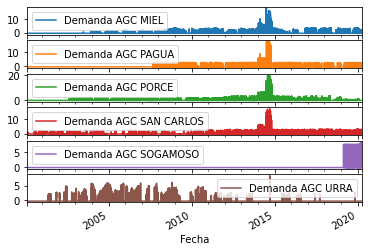

In [4]:
plot_cols = data_horaria_estandarizada.columns[-6:]
plot_features = data_horaria_estandarizada[plot_cols]
_ = plot_features.plot(subplots=True)

In [5]:
full_df = pd.concat([data_horaria_estandarizada,precio_bolsa],axis=1)
full_df.shape,data_horaria_estandarizada.shape,precio_bolsa.shape

((176760, 85), (176760, 84), (176760, 1))

In [6]:
train_df = full_df[(full_df.index >= '2000-01-01') & (full_df.index < '2019-01-01')]
val_df = full_df[(full_df.index >= '2019-01-01') & (full_df.index < '2020-01-01')]
test_df = full_df[full_df.index >= '2020-01-01']

train_df.shape,val_df.shape,test_df.shape

((165816, 85), (8760, 85), (2184, 85))

## Build Window

In [7]:
inputs_columns = ['Generacion ALBAN', 'Generacion BETANIA', 'Generacion CHIVOR',
          'Generacion EL QUIMBO', 'Generacion GUATAPE', 'Generacion GUATRON',
          'Generacion GUAVIO', 'Generacion LA TASAJERA', 'Generacion MIEL',
          'Generacion PAGUA', 'Generacion PLAYAS', 'Generacion PORCE',
          'Generacion SAN CARLOS', 'Generacion SOGAMOSO', 'Generacion URRA','$kWh']
#output_columns = inputs_columns

#inputs_columns = ['$kWh']
output_columns = ['$kWh']



window_dataset = WindowDataset.WindowGenerator(input_width=24, label_width=1, shift=1,
                              train_df=train_df, val_df=val_df, test_df=test_df,
                              inputs_columns=inputs_columns,label_columns=output_columns,batch=8)

# MODELS

## Instantiate Models

In [8]:
custom_rnn  = CustomModels.CustomRNN(rnn_units=90,output_units=len(output_columns))
custom_lstm = CustomModels.CustomLSTM(lstm_units=83,output_units=len(output_columns))
custom_gru  = CustomModels.CustomGRU(gru_units=90,output_units=len(output_columns))
custom_cnn  = CustomModels.CustomCNN(dropout_rate=0.31,output_units=len(output_columns))

## Instantiate metrics dicts

In [9]:
val_performance = dict()
performance = dict()

## Compile & Fit Method

In [10]:
def compile_and_fit(model, window_train, window_val, epochs, steps_per_epoch, val_steps,patience):
    
    log_dir = os.path.join('logs',model.name)
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    callback_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                          histogram_freq=2,
                                                          write_graph=False,
                                                          update_freq='epoch')
    
    callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                              factor=0.1,
                                                              min_lr=1e-4,
                                                              patience=0,
                                                              verbose=1)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    
    callbacks = [callback_tensorboard,callback_reduce_lr,early_stopping]
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(),tf.keras.metrics.MeanAbsolutePercentageError(),
                           CustomMetrics.symmetric_mean_absolute_percentage_error])
    
    history = model.fit(x=window_train,epochs=epochs,steps_per_epoch=steps_per_epoch,
              validation_data=window_val,validation_steps=val_steps,callbacks=callbacks)
    
    return history

## Predictions & Plot

In [11]:
def generate_predictions_style_1(flat_inputs,model):
    """
    Esta función toma una sección del conjunto de Test y entrega predicciones para
    todas las horas posteriores a la 24. Para realizar esto, inicialmente se toman
    las primeras 24 horas de cada una de las series y predice la siguiente   hora,
    luego usa las siguientes 24 horas tomadas del conjunto de Test y le agrega  la
    predicción realizada para predecir la siguiente hora (hora 26) y continua  así
    hasta realizar la predicción de todas las horas del subconjunto tomado de test.
    Input:
        - flat_inputs: Tensor de dimensiones (n_batch*times,n_signals) que contiene
        los valores de las series para un subconjunto de test.
        - model: Modelo entrenado con el cual se realizaran las predicciones.
    Output:
        - predicted_signal: Tensor con dimensiones ((n_batch*times)-23,1) que  con-
        tiene todas las predicciones realizadas sobre el subconjunto de Test.
    """
    flat_inputs_size = flat_inputs.shape[0]

    signals_to_predict = tf.expand_dims(flat_inputs[0:24,:], axis=0)
    predicted_signal = list()
    predicted_signal_idx = 0

    for i in range(1,flat_inputs_size-23):

        predictions = model.predict(signals_to_predict)
        predicted_signal.append(predictions)

        if i >= 24:
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.reshape(flat_predicted_signal[predicted_signal_idx:,-1], [-1,1])
            predicted_signal_idx += 1
        else:
            last_signal = tf.reshape(flat_inputs[i:24,-1], [-1,1])
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.concat([last_signal,flat_predicted_signal],axis=0)

        first_signals = flat_inputs[0+i:24+i,:-1]
        signals_to_predict = tf.concat([first_signals,last_signal],axis=1)
        signals_to_predict = tf.expand_dims(signals_to_predict, axis=0)
    
    return predicted_signal

In [12]:
def generate_predictions_style_2(flat_inputs,model):
    """
    Esta función toma una sección del conjunto de Test y entrega predicciones para
    todas las horas posteriores a la 24. Para realizar esto, inicialmente se toman
    las primeras 24 horas de cada una de las series y predice la siguiente   hora,
    luego usa las siguientes 23 horas tomadas del conjunto de Test y repite el úl-
    timo valor conocido (osea el valor flat_input[23,:]) para poder completar  las
    24 horas, pero esto lo hace unicamente con las series que no estan   incluidas
    en output_columns, para las series que si estan incluidas en   output_columns,
    toma el valor predicho y lo agrega como último a la serie.
    Input:
        - flat_inputs: Tensor de dimensiones (n_batch*times,n_signals) que contiene
        los valores de las series para un subconjunto de test.
        - model: Modelo entrenado con el cual se realizaran las predicciones.
    Output:
        - predicted_signal: Tensor con dimensiones ((n_batch*times)-23,1) que  con-
        tiene todas las predicciones realizadas sobre el subconjunto de Test.
    """
    flat_inputs_size = flat_inputs.shape[0]

    signals_to_predict = tf.expand_dims(flat_inputs[0:24,:], axis=0)

    predicted_signal = list()
    predicted_signal_idx = 0

    for i in range(1,flat_inputs_size-23):

        predictions = model(signals_to_predict)
        predicted_signal.append(predictions)

        if i >= 24:
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.reshape(flat_predicted_signal[predicted_signal_idx:,-1], [-1,1])
            predicted_signal_idx += 1
        else:
            last_signal = tf.reshape(flat_inputs[i:24,-1], [-1,1])
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.concat([last_signal,flat_predicted_signal],axis=0)

            first_signals = flat_inputs[i:24,:-1]
            repeated_signals = tf.repeat(flat_inputs[23:24,:-1], i, axis=0)
            first_signals = tf.concat([first_signals,repeated_signals],axis=0)

        signals_to_predict = tf.concat([first_signals,last_signal],axis=1)
        signals_to_predict = tf.expand_dims(signals_to_predict, axis=0)
    
    return predicted_signal

In [13]:
def generate_predictions_style_3(flat_inputs,model):
    """
    Esta función toma una sección del conjunto de Test y entrega predicciones para
    todas las horas posteriores a la 24. Para realizar esto, inicialmente se toman
    las primeras 24 horas de cada una de las series y predice la siguiente   hora,
    luego usa las mismas 24 de las series que no estan incluidas en output_columns 
    y para las series que si estan incluidas allí toma los 23 valores siguiente  y
    agrega la predicción realizada, así suscesivamente hasta acabar las    predic-
    ciones.
    Input:
        - flat_inputs: Tensor de dimensiones (n_batch*times,n_signals) que contiene
        los valores de las series para un subconjunto de test.
        - model: Modelo entrenado con el cual se realizaran las predicciones.
    Output:
        - predicted_signal: Tensor con dimensiones ((n_batch*times)-23,1) que  con-
        tiene todas las predicciones realizadas sobre el subconjunto de Test.
    """
    flat_inputs_size = flat_inputs.shape[0]

    signals_to_predict = tf.expand_dims(flat_inputs[0:24,:], axis=0)

    predicted_signal = list()
    predicted_signal_idx = 0

    for i in range(1,flat_inputs_size-23):

        predictions = model(signals_to_predict)
        predicted_signal.append(predictions)

        if i >= 24:
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.reshape(flat_predicted_signal[predicted_signal_idx:,-1], [-1,1])
            predicted_signal_idx += 1
        else:
            last_signal = tf.reshape(flat_inputs[i:24,-1], [-1,1])
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.concat([last_signal,flat_predicted_signal],axis=0)

        first_signals = flat_inputs[:24,:-1]
        signals_to_predict = tf.concat([first_signals,last_signal],axis=1)
        signals_to_predict = tf.expand_dims(signals_to_predict, axis=0)
    
    return predicted_signal

In [14]:
def plot_comparison(signal_true,signal_pred):
    y_true = signal_true[24:,-1]
    y_pred = tf.reshape(tf.convert_to_tensor(signal_pred),[-1,1])
    
    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))

    # Plot and compare the two signals.
    plt.plot(y_true, label='true')
    plt.plot(y_pred, label='pred')

    plt.ylabel('Precio en Bolsa Nacional')
    plt.legend()
    plt.show()

## Execute experiments

### Recurrent Neuronal Network

In [15]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomRNN(rnn_units=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_rnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 83)                8300      
_________________________________________________________________
dense (Dense)                (None, 1)                 84        
Total params: 8,384
Trainable params: 8,384
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = compile_and_fit(model=custom_rnn, window_train=window_dataset.train,
                          window_val=window_dataset.val,epochs=100,
                          steps_per_epoch=150,val_steps=150,patience=5)

Epoch 1/100
  1/150 [..............................] - ETA: 0s - loss: 2.1395 - mean_absolute_error: 1.2448 - mean_absolute_percentage_error: 452.3664 - symmetric_mean_absolute_percentage_error: 183.7140WARNING:tensorflow:From C:\Users\SEBASTIAN\anaconda3\envs\proyecto-grados\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
150/150 [==============================] - 6s 40ms/step - loss: 0.3456 - mean_absolute_error: 0.3337 - mean_absolute_percentage_error: 413.1530 - symmetric_mean_absolute_percentage_error: 79.1740 - val_loss: 0.1325 - val_mean_absolute_error: 0.2731 - val_mean_absolute_percentage_error: 791.2552 - val_symmetric_mean_absolute_percentage_error: 66.4661
Epoch 2/100
150/150 [==============================] - 5s 33ms/step - loss: 0.0676 - mean_absolute_error: 0.1838 - mean_absolute_percentag

In [17]:
val_performance['DNN'] = custom_rnn.evaluate(window_dataset.val)
performance['DNN'] = custom_rnn.evaluate(window_dataset.test, verbose=0)

1092/1092 [==============================] - 7s 7ms/step - loss: 0.0731 - mean_absolute_error: 0.1848 - mean_absolute_percentage_error: 258.0749 - symmetric_mean_absolute_percentage_error: 46.7250: 4s - loss: 0.0680 - mean_absolute_erro


In [18]:
example = window_dataset.test.take(1)
inputs, labels = next(iter(example))

flat_inputs = tf.reshape(inputs, [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

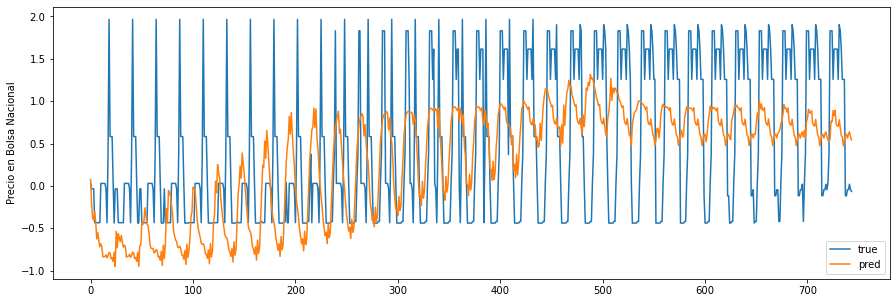

In [19]:
predictions = generate_predictions_style_1(flat_inputs,custom_rnn)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

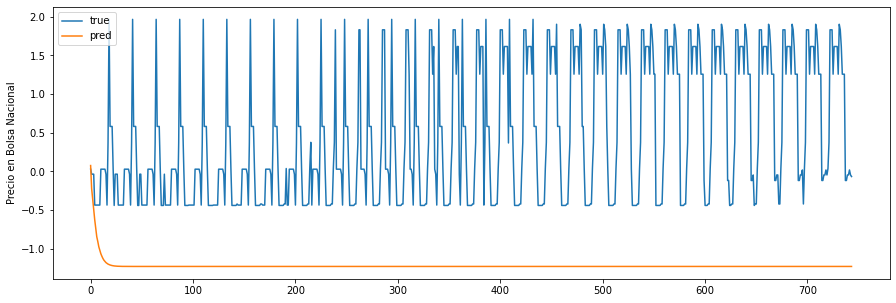

In [20]:
predicted_signal = generate_predictions_style_2(flat_inputs,custom_rnn)
plot_comparison(flat_inputs,predicted_signal)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

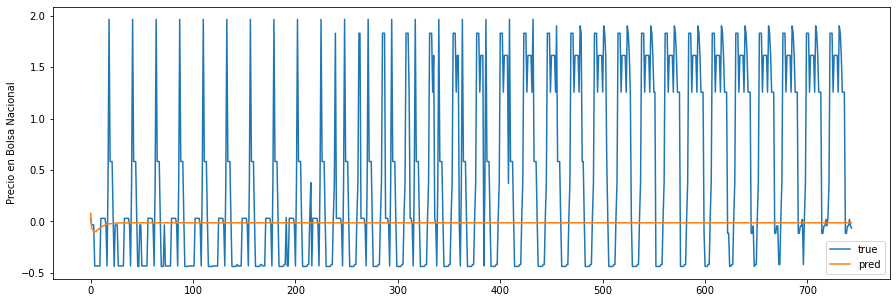

In [21]:
predicted_signal = generate_predictions_style_3(flat_inputs,custom_rnn)
plot_comparison(flat_inputs,predicted_signal)

### Long Short Term Memory

In [22]:
inputs = tf.keras.layers.Input(shape=(24,85))
custom_model = CustomModels.CustomLSTM(lstm_units=83,output_units=85)
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_lstm_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 83)                56108     
_________________________________________________________________
dense_1 (Dense)              (None, 85)                7140      
Total params: 63,248
Trainable params: 63,248
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = compile_and_fit(model=custom_lstm, window_train=window_dataset.train,
                          window_val=window_dataset.val,epochs=100,
                          steps_per_epoch=150,val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 7s 45ms/step - loss: 0.3163 - mean_absolute_error: 0.2223 - mean_absolute_percentage_error: 200.2498 - symmetric_mean_absolute_percentage_error: 63.2825 - val_loss: 0.1325 - val_mean_absolute_error: 0.2721 - val_mean_absolute_percentage_error: 691.0769 - val_symmetric_mean_absolute_percentage_error: 69.9332
Epoch 2/100
150/150 [==============================] - 2s 12ms/step - loss: 0.1753 - mean_absolute_error: 0.1705 - mean_absolute_percentage_error: 97.1483 - symmetric_mean_absolute_percentage_error: 48.0653 - val_loss: 0.1198 - val_mean_absolute_error: 0.2533 - val_mean_absolute_percentage_error: 175.4259 - val_symmetric_mean_absolute_percentage_error: 62.2784
Epoch 3/100
150/150 [==============================] - 2s 14ms/step - loss: 0.0664 - mean_absolute_error: 0.1389 - mean_absolute_percentage_error: 113.8393 - symmetric_mean_absolute_percentage_error: 45.0929 - val_loss: 0.0990 - val_mean_absolute_error: 0.2330 - val_mean_a

150/150 [==============================] - 3s 17ms/step - loss: 0.0376 - mean_absolute_error: 0.0874 - mean_absolute_percentage_error: 45.7839 - symmetric_mean_absolute_percentage_error: 30.4261 - val_loss: 0.0666 - val_mean_absolute_error: 0.1759 - val_mean_absolute_percentage_error: 402.9930 - val_symmetric_mean_absolute_percentage_error: 52.1788
Epoch 22/100
150/150 [==============================] - 3s 17ms/step - loss: 0.0400 - mean_absolute_error: 0.0866 - mean_absolute_percentage_error: 172.8686 - symmetric_mean_absolute_percentage_error: 31.7938 - val_loss: 0.0665 - val_mean_absolute_error: 0.1773 - val_mean_absolute_percentage_error: 384.1947 - val_symmetric_mean_absolute_percentage_error: 52.4086


In [24]:
val_performance['LSTM'] = custom_lstm.evaluate(window_dataset.val)
performance['LSTM'] = custom_lstm.evaluate(window_dataset.test, verbose=0)

1092/1092 [==============================] - 8s 7ms/step - loss: 0.0689 - mean_absolute_error: 0.1809 - mean_absolute_percentage_error: 329.9860 - symmetric_mean_absolute_percentage_error: 49.8701


In [25]:
example = window_dataset.test.take(1)
inputs, labels = next(iter(example))

flat_inputs = tf.reshape(inputs, [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

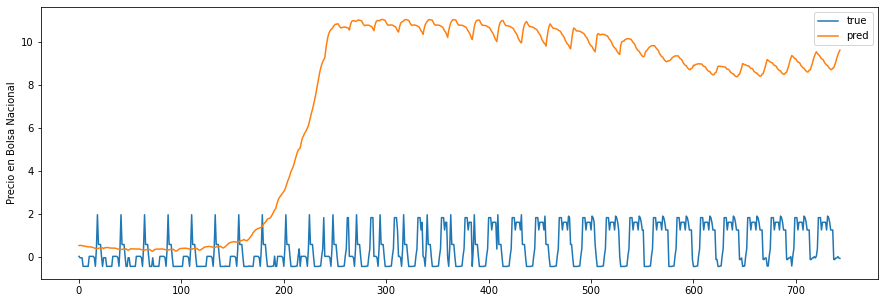

In [26]:
predictions = generate_predictions_style_1(flat_inputs,custom_lstm)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

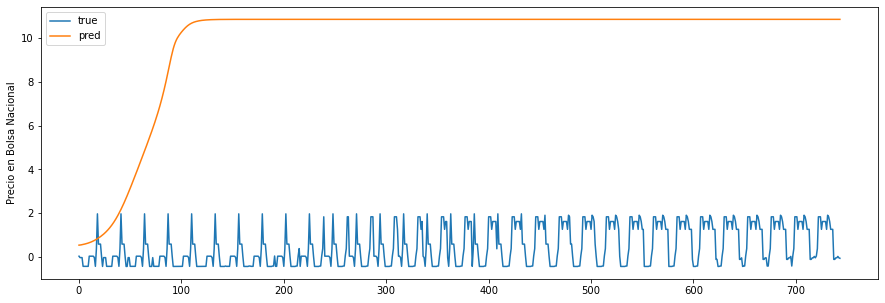

In [27]:
predictions = generate_predictions_style_2(flat_inputs,custom_lstm)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

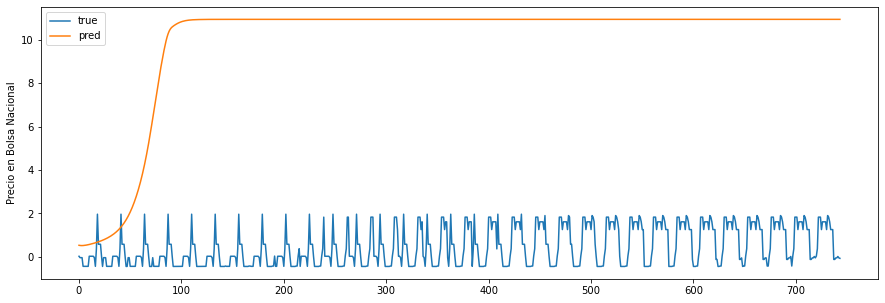

In [28]:
predictions = generate_predictions_style_3(flat_inputs,custom_lstm)
plot_comparison(flat_inputs,predictions)

### Gated Recurrent Unit

In [29]:
inputs = tf.keras.layers.Input(shape=(24,85))
custom_model = CustomModels.CustomGRU(gru_units=83,output_units=85)
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_gru_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 83)                42330     
_________________________________________________________________
dense_2 (Dense)              (None, 85)                7140      
Total params: 49,470
Trainable params: 49,470
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = compile_and_fit(model=custom_gru, window_train=window_dataset.train,
                          window_val=window_dataset.val,epochs=100,
                          steps_per_epoch=150,val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 19s 126ms/step - loss: 0.1738 - mean_absolute_error: 0.2138 - mean_absolute_percentage_error: 123.5610 - symmetric_mean_absolute_percentage_error: 60.5920 - val_loss: 0.1016 - val_mean_absolute_error: 0.2336 - val_mean_absolute_percentage_error: 290.6652 - val_symmetric_mean_absolute_percentage_error: 51.8722
Epoch 2/100
150/150 [==============================] - 14s 94ms/step - loss: 0.1677 - mean_absolute_error: 0.1516 - mean_absolute_percentage_error: 138.5798 - symmetric_mean_absolute_percentage_error: 47.1080 - val_loss: 0.0665 - val_mean_absolute_error: 0.1845 - val_mean_absolute_percentage_error: 334.3018 - val_symmetric_mean_absolute_percentage_error: 46.9966
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 0.0482 - mean_absolute_error: 0.1307 - mean_absolute_percentage_error: 107.3142 - symmetric_mean_absolute_percentage_error: 41.7731
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001000

In [31]:
val_performance['GRU'] = custom_gru.evaluate(window_dataset.val)
performance['GRU'] = custom_gru.evaluate(window_dataset.test, verbose=0)

1092/1092 [==============================] - 11s 10ms/step - loss: 0.0559 - mean_absolute_error: 0.1496 - mean_absolute_percentage_error: 152.2512 - symmetric_mean_absolute_percentage_error: 40.0598


In [32]:
example = window_dataset.test.take(1)
inputs, labels = next(iter(example))

flat_inputs = tf.reshape(inputs, [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

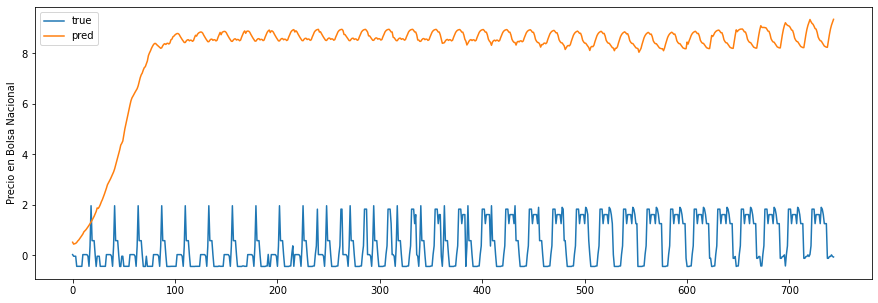

In [33]:
predictions = generate_predictions_style_1(flat_inputs,custom_gru)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

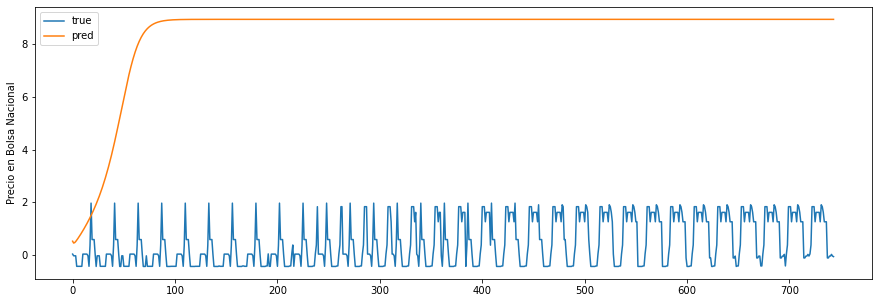

In [34]:
predictions = generate_predictions_style_2(flat_inputs,custom_gru)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

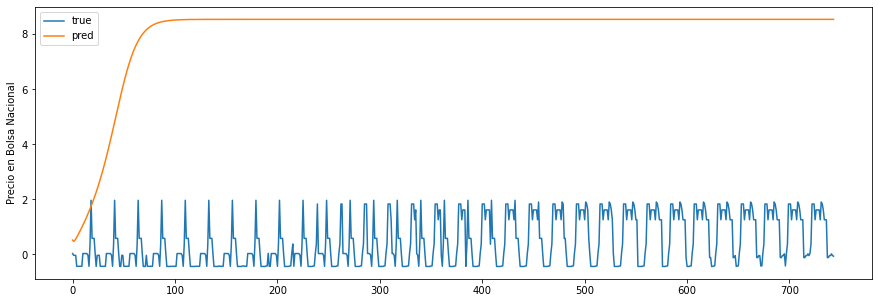

In [35]:
predictions = generate_predictions_style_3(flat_inputs,custom_gru)
plot_comparison(flat_inputs,predictions)

### Convolutional Neuronal Network

In [36]:
inputs = tf.keras.layers.Input(shape=(24,85))
custom_model = CustomModels.CustomCNN(dropout_rate=83,output_units=85)
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 23, 64)            10944     
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 64)            256       
_________________________________________________________________
activation (Activation)      (None, 23, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 64)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 85)               

In [37]:
history = compile_and_fit(model=custom_cnn, window_train=window_dataset.train,
                          window_val=window_dataset.val,epochs=100,
                          steps_per_epoch=150,val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 6s 39ms/step - loss: 1.2600 - mean_absolute_error: 0.7110 - mean_absolute_percentage_error: 325.5153 - symmetric_mean_absolute_percentage_error: 119.4653 - val_loss: 0.3287 - val_mean_absolute_error: 0.4515 - val_mean_absolute_percentage_error: 1045.8865 - val_symmetric_mean_absolute_percentage_error: 96.5219
Epoch 2/100
150/150 [==============================] - 2s 14ms/step - loss: 0.5929 - mean_absolute_error: 0.5467 - mean_absolute_percentage_error: 714.3022 - symmetric_mean_absolute_percentage_error: 110.1516 - val_loss: 0.1854 - val_mean_absolute_error: 0.3341 - val_mean_absolute_percentage_error: 832.0212 - val_symmetric_mean_absolute_percentage_error: 74.7934
Epoch 3/100
150/150 [==============================] - 2s 14ms/step - loss: 0.5849 - mean_absolute_error: 0.5088 - mean_absolute_percentage_error: 631.5023 - symmetric_mean_absolute_percentage_error: 108.7189 - val_loss: 0.1794 - val_mean_absolute_error: 0.3261 - val_m

Epoch 21/100
150/150 [==============================] - 1s 10ms/step - loss: 0.2738 - mean_absolute_error: 0.3935 - mean_absolute_percentage_error: 543.9128 - symmetric_mean_absolute_percentage_error: 95.1394 - val_loss: 0.1385 - val_mean_absolute_error: 0.2735 - val_mean_absolute_percentage_error: 274.3957 - val_symmetric_mean_absolute_percentage_error: 68.0096
Epoch 22/100
150/150 [==============================] - 2s 12ms/step - loss: 0.5925 - mean_absolute_error: 0.4650 - mean_absolute_percentage_error: 259.9713 - symmetric_mean_absolute_percentage_error: 98.9062 - val_loss: 0.1361 - val_mean_absolute_error: 0.2722 - val_mean_absolute_percentage_error: 335.2506 - val_symmetric_mean_absolute_percentage_error: 67.0672
Epoch 23/100
150/150 [==============================] - 2s 13ms/step - loss: 0.3656 - mean_absolute_error: 0.4184 - mean_absolute_percentage_error: 338.0961 - symmetric_mean_absolute_percentage_error: 98.5683 - val_loss: 0.1361 - val_mean_absolute_error: 0.2700 - val_me

In [38]:
val_performance['CNN'] = custom_cnn.evaluate(window_dataset.val)
performance['CNN'] = custom_cnn.evaluate(window_dataset.test, verbose=0)

1092/1092 [==============================] - 5s 5ms/step - loss: 0.1383 - mean_absolute_error: 0.2753 - mean_absolute_percentage_error: 337.4301 - symmetric_mean_absolute_percentage_error: 67.2477


In [39]:
example = window_dataset.test.take(1)
inputs, labels = next(iter(example))

flat_inputs = tf.reshape(inputs, [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

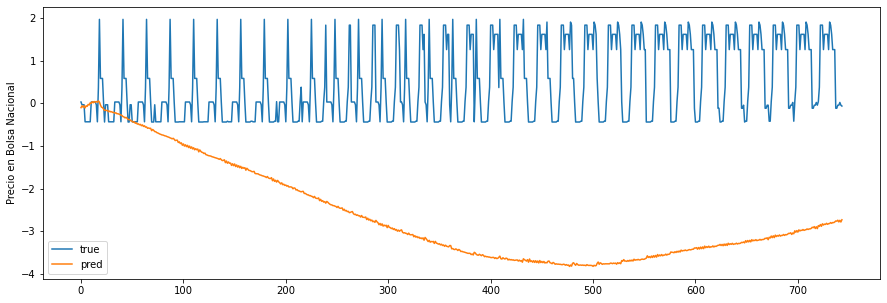

In [40]:
predictions = generate_predictions_style_1(flat_inputs,custom_cnn)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

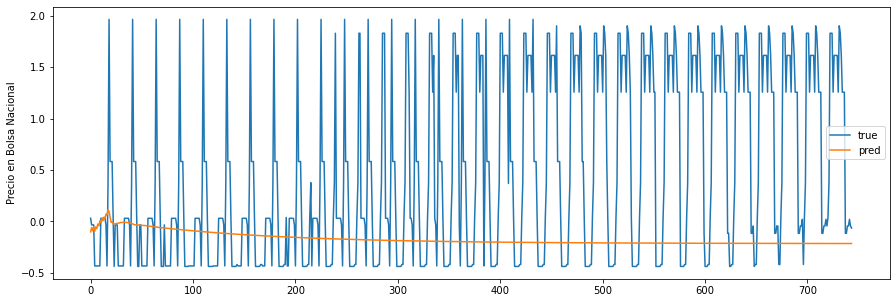

In [41]:
predictions = generate_predictions_style_2(flat_inputs,custom_cnn)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

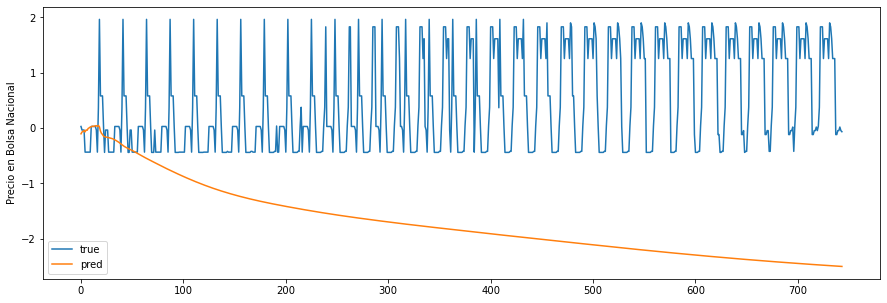

In [42]:
predictions = generate_predictions_style_3(flat_inputs,custom_cnn)
plot_comparison(flat_inputs,predictions)

## Metrics Summary

In [43]:
pd.DataFrame(val_performance,index=['Loss','Mean Absolute Error',
                                    'Mean Absolute Percentage Error',
                                    'Symetric Mean Absolute Percentage Error']).T

,Loss,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
DNN,0.073076,0.184765,258.074860,46.725002
LSTM,0.068855,0.180880,329.985962,49.870125
GRU,0.055881,0.149596,152.251236,40.059761
CNN,0.138282,0.275332,337.430115,67.247726


In [44]:
pd.DataFrame(performance,index=['Loss','Mean Absolute Error',
                                'Mean Absolute Percentage Error',
                                'Symetric Mean Absolute Percentage Error']).T

,Loss,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
DNN,0.079881,0.208573,21.317081,17.199495
LSTM,0.076173,0.192875,24.122076,15.674532
GRU,0.059573,0.157697,17.782623,12.615251
CNN,0.174425,0.295727,48.510723,22.320471


# MODELO DE DATOS PROPIO

In [45]:
inputs_columns = ['Generacion ALBAN', 'Generacion BETANIA',      'Generacion CHIVOR',
                  'Generacion EL QUIMBO', 'Generacion GUATAPE', 'Generacion GUATRON',
                  'Generacion GUAVIO', 'Generacion LA TASAJERA',   'Generacion MIEL',
                  'Generacion PAGUA', 'Generacion PLAYAS',        'Generacion PORCE',
                  'Generacion SAN CARLOS', 'Generacion SOGAMOSO',  'Generacion URRA',
                  '$kWh']

output_columns = ['$kWh']

column_indices = {name: i for i, name in enumerate(full_df)}
times = 24
shift = 1

In [46]:
samples = train_df.shape[0] - (times+shift)
custom_window_generator = CustomWindowGenerator.WindowGenerator(samples=samples,
                                                                times=times,
                                                                shift=shift,
                                                                inputs_columns=inputs_columns,
                                                                output_columns=output_columns,
                                                                column_indices=column_indices)

x_train, y_train = custom_window_generator.data_build(train_df)
train_generator = custom_window_generator.batch_generator(x=x_train,y=y_train,batches=8)

x_batch, y_batch = next(train_generator)
x_batch.shape,y_batch.shape

((8, 24, 16), (8, 24, 1))

In [47]:
samples = val_df.shape[0] - (times+shift)
custom_window_generator = CustomWindowGenerator.WindowGenerator(samples=samples,
                                                                times=times,
                                                                shift=shift,
                                                                inputs_columns=inputs_columns,
                                                                output_columns=output_columns,
                                                                column_indices=column_indices)

x_val, y_val = custom_window_generator.data_build(val_df)
val_generator = custom_window_generator.batch_generator(x_val, y_val,batches=8)

x_batch, y_batch = next(val_generator)
x_batch.shape,y_batch.shape

((8, 24, 16), (8, 24, 1))

In [48]:
samples = test_df.shape[0] - (times+shift)
custom_window_generator = CustomWindowGenerator.WindowGenerator(samples=samples,
                                                                times=times,
                                                                shift=shift,
                                                                inputs_columns=inputs_columns,
                                                                output_columns=output_columns,
                                                                column_indices=column_indices)

x_test, y_test = custom_window_generator.data_build(test_df)
test_generator = custom_window_generator.batch_generator(x_test, y_test,batches=8,shuffle=False)

x_batch, y_batch = next(test_generator)
x_batch.shape,y_batch.shape

((8, 24, 16), (8, 24, 1))

## Instantiate Models

In [49]:
custom_rnn_2  = CustomModels.CustomRNN(rnn_units=90,output_units=len(output_columns))
custom_lstm_2 = CustomModels.CustomLSTM(lstm_units=83,output_units=len(output_columns))
custom_gru_2  = CustomModels.CustomGRU(gru_units=90,output_units=len(output_columns))
custom_cnn_2  = CustomModels.CustomCNN(dropout_rate=0.31,output_units=len(output_columns))

## Execute Experiments

### Recurrent Neuronal Network

In [50]:
history = compile_and_fit(model=custom_rnn_2, window_train=train_generator,
                          window_val=val_generator,epochs=100,steps_per_epoch=150,
                          val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 8s 53ms/step - loss: 0.4365 - mean_absolute_error: 0.3522 - mean_absolute_percentage_error: 243.9232 - symmetric_mean_absolute_percentage_error: 2115.1021 - val_loss: 0.1195 - val_mean_absolute_error: 0.2639 - val_mean_absolute_percentage_error: 151.5131 - val_symmetric_mean_absolute_percentage_error: 1590.1741
Epoch 2/100
150/150 [==============================] - 5s 30ms/step - loss: 0.1940 - mean_absolute_error: 0.2077 - mean_absolute_percentage_error: 113.8861 - symmetric_mean_absolute_percentage_error: 1434.6289 - val_loss: 0.0812 - val_mean_absolute_error: 0.2032 - val_mean_absolute_percentage_error: 359.9026 - val_symmetric_mean_absolute_percentage_error: 1258.7172
Epoch 3/100
150/150 [==============================] - ETA: 0s - loss: 0.0913 - mean_absolute_error: 0.1759 - mean_absolute_percentage_error: 259.6234 - symmetric_mean_absolute_percentage_error: 1346.8047
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.

In [51]:
val_performance['RNN-CustomDataset'] = custom_rnn_2.evaluate(val_generator,steps=100)
performance['RNN-CustomDataset'] = custom_rnn_2.evaluate(test_generator,steps=100, verbose=0)

100/100 [==============================] - 1s 8ms/step - loss: 0.0694 - mean_absolute_error: 0.1860 - mean_absolute_percentage_error: 223.2630 - symmetric_mean_absolute_percentage_error: 1213.6226


In [52]:
x_batch, _ = next(test_generator)

flat_inputs = tf.reshape(tf.convert_to_tensor(x_batch,dtype=np.float32), [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

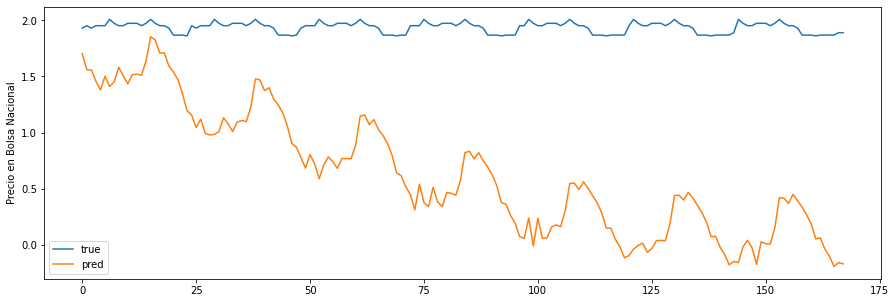

In [53]:
predictions = generate_predictions_style_1(flat_inputs,custom_rnn_2)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

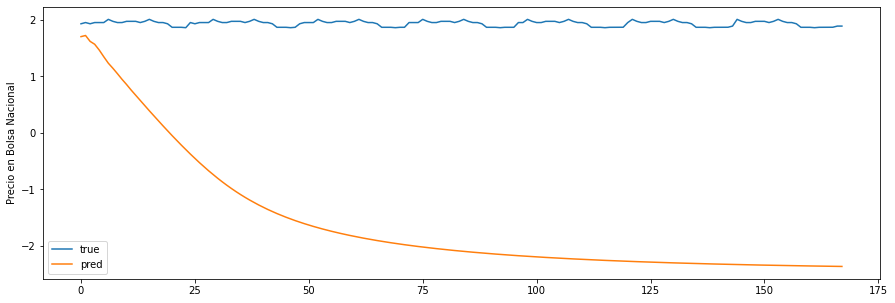

In [54]:
predictions = generate_predictions_style_2(flat_inputs,custom_rnn_2)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

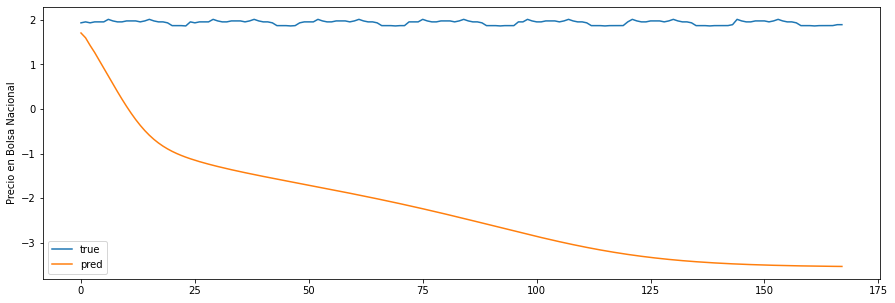

In [55]:
predictions = generate_predictions_style_3(flat_inputs,custom_rnn_2)
plot_comparison(flat_inputs,predictions)

### Long Short Term Memory

In [56]:
history = compile_and_fit(model=custom_lstm_2, window_train=train_generator,
                          window_val=val_generator,epochs=100,steps_per_epoch=150,
                          val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 6s 40ms/step - loss: 0.2749 - mean_absolute_error: 0.2695 - mean_absolute_percentage_error: 197.5264 - symmetric_mean_absolute_percentage_error: 1760.5002 - val_loss: 0.1989 - val_mean_absolute_error: 0.3490 - val_mean_absolute_percentage_error: 264.7223 - val_symmetric_mean_absolute_percentage_error: 1974.2766
Epoch 2/100
150/150 [==============================] - 2s 17ms/step - loss: 0.0981 - mean_absolute_error: 0.1595 - mean_absolute_percentage_error: 189.5107 - symmetric_mean_absolute_percentage_error: 1180.6426 - val_loss: 0.0929 - val_mean_absolute_error: 0.2296 - val_mean_absolute_percentage_error: 298.2885 - val_symmetric_mean_absolute_percentage_error: 1402.0421
Epoch 3/100
149/150 [============================>.] - ETA: 0s - loss: 0.0739 - mean_absolute_error: 0.1360 - mean_absolute_percentage_error: 97.6507 - symmetric_mean_absolute_percentage_error: 1038.9553 
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.

In [57]:
val_performance['LSTM-CustomDataset'] = custom_cnn.evaluate(val_generator,steps=100)
performance['LSTM-CustomDataset'] = custom_cnn.evaluate(test_generator,steps=100, verbose=0)

100/100 [==============================] - 1s 5ms/step - loss: 0.1457 - mean_absolute_error: 0.2850 - mean_absolute_percentage_error: 322.5533 - symmetric_mean_absolute_percentage_error: 1554.7885


In [58]:
x_batch, _ = next(test_generator)

flat_inputs = tf.reshape(tf.convert_to_tensor(x_batch,dtype=np.float32), [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

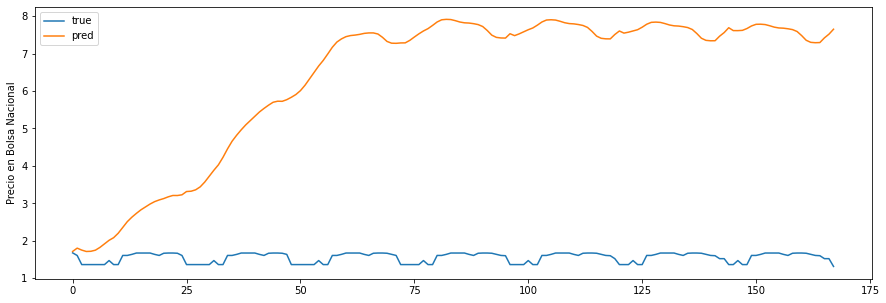

In [59]:
predictions = generate_predictions_style_1(flat_inputs,custom_lstm_2)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

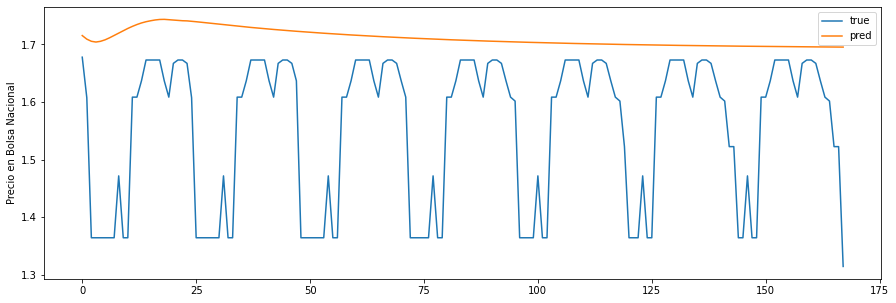

In [60]:
predictions = generate_predictions_style_2(flat_inputs,custom_lstm_2)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

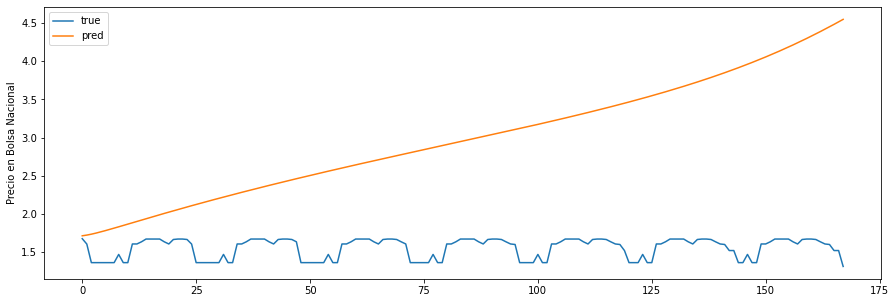

In [61]:
predictions = generate_predictions_style_3(flat_inputs,custom_lstm_2)
plot_comparison(flat_inputs,predictions)

### Gated Recurrent Unit

In [62]:
history = compile_and_fit(model=custom_gru_2, window_train=train_generator,
                          window_val=val_generator,epochs=100,steps_per_epoch=150,
                          val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 7s 45ms/step - loss: 0.2577 - mean_absolute_error: 0.2324 - mean_absolute_percentage_error: 163.3058 - symmetric_mean_absolute_percentage_error: 1528.7703 - val_loss: 0.1138 - val_mean_absolute_error: 0.2641 - val_mean_absolute_percentage_error: 252.1654 - val_symmetric_mean_absolute_percentage_error: 1614.4066
Epoch 2/100
150/150 [==============================] - 2s 15ms/step - loss: 0.0496 - mean_absolute_error: 0.1156 - mean_absolute_percentage_error: 405.0688 - symmetric_mean_absolute_percentage_error: 985.3131 - val_loss: 0.0602 - val_mean_absolute_error: 0.1778 - val_mean_absolute_percentage_error: 132.1379 - val_symmetric_mean_absolute_percentage_error: 1132.7935
Epoch 3/100
149/150 [============================>.] - ETA: 0s - loss: 0.0547 - mean_absolute_error: 0.1227 - mean_absolute_percentage_error: 112.3251 - symmetric_mean_absolute_percentage_error: 962.1165
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00

In [63]:
val_performance['GRU-CustomDataset'] = custom_gru_2.evaluate(val_generator,steps=100)
performance['GRU-CustomDataset'] = custom_gru_2.evaluate(test_generator,steps=100, verbose=0)

100/100 [==============================] - 1s 6ms/step - loss: 0.0465 - mean_absolute_error: 0.1374 - mean_absolute_percentage_error: 97.9817 - symmetric_mean_absolute_percentage_error: 907.4760


In [64]:
x_batch, _ = next(test_generator)

flat_inputs = tf.reshape(tf.convert_to_tensor(x_batch,dtype=np.float32), [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

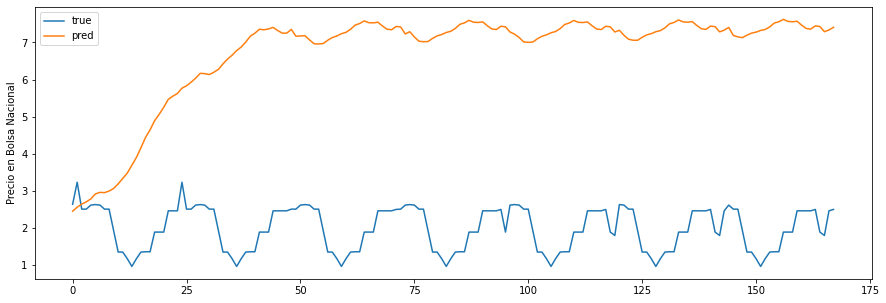

In [65]:
predictions = generate_predictions_style_1(flat_inputs,custom_gru_2)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

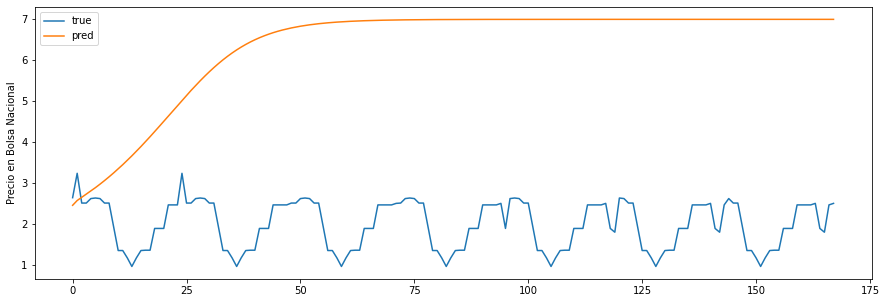

In [66]:
predictions = generate_predictions_style_2(flat_inputs,custom_gru_2)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

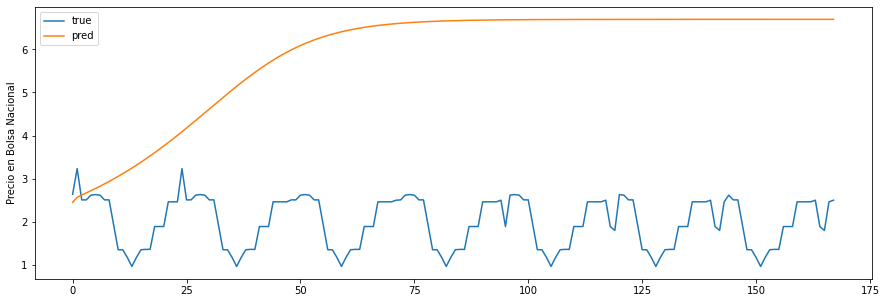

In [67]:
predictions = generate_predictions_style_3(flat_inputs,custom_gru_2)
plot_comparison(flat_inputs,predictions)

### Convolutional Neuronal Network

In [68]:
history = compile_and_fit(model=custom_cnn_2, window_train=train_generator,
                          window_val=val_generator,epochs=100,steps_per_epoch=150,
                          val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 5s 36ms/step - loss: 0.9361 - mean_absolute_error: 0.6955 - mean_absolute_percentage_error: 803.4376 - symmetric_mean_absolute_percentage_error: 3044.2197 - val_loss: 0.3170 - val_mean_absolute_error: 0.4443 - val_mean_absolute_percentage_error: 687.4592 - val_symmetric_mean_absolute_percentage_error: 2154.2554
Epoch 2/100
150/150 [==============================] - 2s 14ms/step - loss: 0.6538 - mean_absolute_error: 0.5779 - mean_absolute_percentage_error: 440.4826 - symmetric_mean_absolute_percentage_error: 2686.2522 - val_loss: 0.2227 - val_mean_absolute_error: 0.3727 - val_mean_absolute_percentage_error: 464.9488 - val_symmetric_mean_absolute_percentage_error: 1938.0295
Epoch 3/100
150/150 [==============================] - 2s 13ms/step - loss: 0.5109 - mean_absolute_error: 0.5143 - mean_absolute_percentage_error: 430.0212 - symmetric_mean_absolute_percentage_error: 2569.1194 - val_loss: 0.2212 - val_mean_absolute_error: 0.3688 -

In [69]:
val_performance['CNN-CustomDataset'] = custom_cnn_2.evaluate(val_generator,steps=100)
performance['CNN-CustomDataset'] = custom_cnn_2.evaluate(test_generator,steps=100, verbose=0)

100/100 [==============================] - 0s 4ms/step - loss: 0.1492 - mean_absolute_error: 0.2846 - mean_absolute_percentage_error: 203.9028 - symmetric_mean_absolute_percentage_error: 1587.3311


In [70]:
x_batch, _ = next(test_generator)

flat_inputs = tf.reshape(tf.convert_to_tensor(x_batch,dtype=np.float32), [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

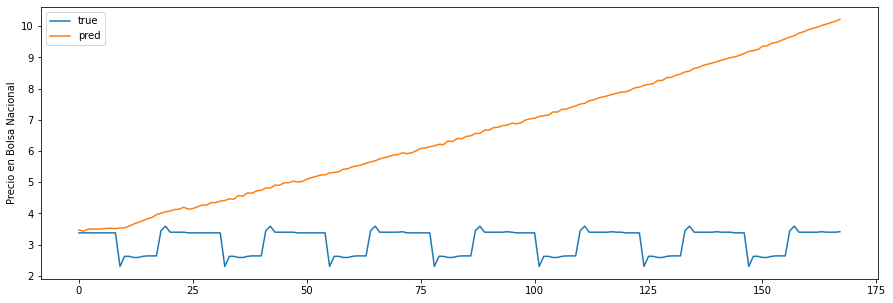

In [71]:
predictions = generate_predictions_style_1(flat_inputs,custom_cnn_2)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

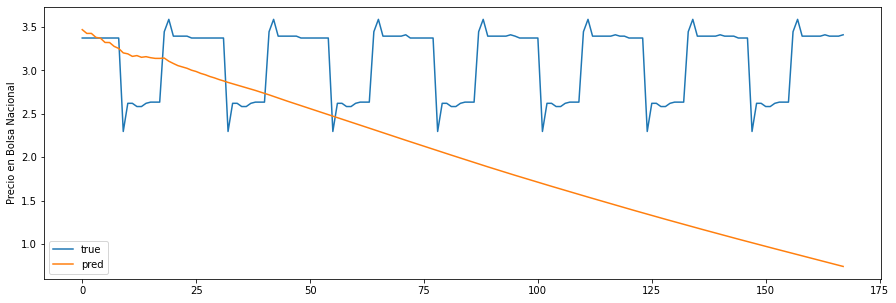

In [72]:
predictions = generate_predictions_style_2(flat_inputs,custom_cnn_2)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

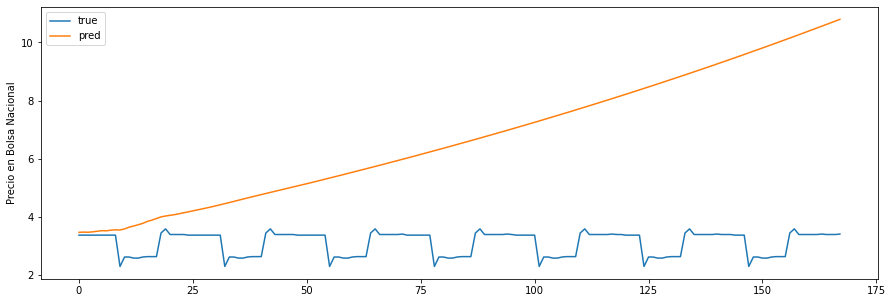

In [73]:
predictions = generate_predictions_style_3(flat_inputs,custom_cnn_2)
plot_comparison(flat_inputs,predictions)

## Metrics Summary

In [74]:
pd.DataFrame(val_performance,index=['Loss','Mean Absolute Error',
                                    'Mean Absolute Percentage Error',
                                    'Symetric Mean Absolute Percentage Error']).T

,Loss,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
DNN,0.073076,0.184765,258.074860,46.725002
LSTM,0.068855,0.180880,329.985962,49.870125
GRU,0.055881,0.149596,152.251236,40.059761
CNN,0.138282,0.275332,337.430115,67.247726
RNN-CustomDataset,0.069412,0.185979,223.263031,1213.622559
LSTM-CustomDataset,0.145690,0.284960,322.553314,1554.788452
GRU-CustomDataset,0.046525,0.137390,97.981682,907.475952
CNN-CustomDataset,0.149235,0.284613,203.902756,1587.331055


In [75]:
pd.DataFrame(performance,index=['Loss','Mean Absolute Error',
                                'Mean Absolute Percentage Error',
                                'Symetric Mean Absolute Percentage Error']).T

,Loss,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
DNN,0.079881,0.208573,21.317081,17.199495
LSTM,0.076173,0.192875,24.122076,15.674532
GRU,0.059573,0.157697,17.782623,12.615251
CNN,0.174425,0.295727,48.510723,22.320471
RNN-CustomDataset,0.085401,0.208295,20.617563,395.984802
LSTM-CustomDataset,0.192973,0.305219,44.674007,521.172668
GRU-CustomDataset,0.062305,0.163198,14.091352,288.041626
CNN-CustomDataset,0.200981,0.345743,36.354671,552.456421
